In [53]:
# The code was removed by Watson Studio for sharing.

In [54]:
!pip install catboost | tail -n 1
!pip install scikit-plot | tail -n 1
!pip install nltk | tail -n 1
!pip install gensim | tail -n 1

In [55]:
import pandas as pd
import numpy as np

import re, math, os

import string

from collections import Counter, defaultdict

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as ctb
#import lightgbm as lgb

from sklearn.metrics import accuracy_score, f1_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [56]:
# The code was removed by Watson Studio for sharing.

In [57]:
with open("imdb.zip", "wb") as outfile:
    # Copy the BytesIO stream to the output file
    outfile.write(data.read())

In [58]:
from zipfile import ZipFile

with ZipFile('imdb.zip', 'r') as zipObj:
    zipObj.extractall()

Function for Preprocessing

In [59]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wsuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


class Preprocessing():
    
    def lowercase(self, text: pd.core.series.Series):
        return text.str.lower()

    def remove_digits(self, text: pd.core.series.Series):
        return text.str.replace('\d+', '', regex = True)

    def remove_punctuation(self, text: pd.core.series.Series):
        return text.str.replace('[{}]'.format(string.punctuation), '', regex = True)

    def remove_whitespaces(self, text: pd.core.series.Series):
        text = text.replace('\s+',' ', regex=True)
        return text[text != ' ']

    def remove_newlines(self, text: pd.core.series.Series):
        return text.str.replace(r'\n', '', regex = True)

    def remove_stopwords(self, text: pd.core.series.Series):
        return text.apply(lambda x: ' '.join([w for w in x.split() if not w in stop_words]))

    def lemmatizing(self, text: pd.core.series.Series):
        return text.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))

    def mapping_english(self, text: pd.core.series.Series):
        return text.apply(lambda x: True if re.search(u'[\x80-\U0010ffff]', x) == None else False)

    def check_nans(self, text: pd.core.series.Series):
        if text.isnull().sum() == 0:
            print('No NaNs')
        else:
            print('Dropping NaNs')
            text.dropna()
        return text
    
    def transform(self, text, 
                 lowercase = True, remove_dig = True, remove_punc = True, 
                 whitespaces = True, newlines = True, stopwords = True, lemmatize = True):
        if lowercase:
            text = self.lowercase(text)
        if remove_dig:
            text = self.remove_digits(text)
        if remove_punc:
            text = self.remove_punctuation(text)
        if whitespaces:
            text = self.remove_whitespaces(text)
        if newlines:
            text = self.remove_newlines(text)
        if stopwords:
            text = self.remove_stopwords(text)
        if lemmatize:
            text = self.lemmatizing(text)
        return text   

Creating training set

In [61]:
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [62]:
# create and load df from lists 'labels' and 'texts'
df_train = pd.DataFrame(columns=['labels', 'texts'])
df_train['labels']=labels
df_train['texts']=texts
#mixing
df_train = df_train.sample(frac = 1.0, random_state=33)
df_train

,labels,texts
17797,1,This was Barbra Streisand's first television s...
6458,0,"I think Jason Lee has huge potential, but this..."
14478,1,"Having developed a critical eye for film, and ..."
14825,1,This picks up about a year after the events in...
7523,0,"This movie could have been very good, but come..."
...,...,...
57,0,Even the first 10 minutes of this movie were h...
578,0,"I confess--Emma, in my opinion, is the single ..."
5848,0,I rented this horrible movie. The worst think ...
2439,0,"I wouldn't normally write a comment on-line, b..."


Creating test set

In [63]:
imdb_dir = './aclImdb'
test_dir = os.path.join(imdb_dir, 'test')

labels_test = []
texts_test = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts_test.append(f.read())
            f.close()
            if label_type == 'neg':
                labels_test.append(0)
            else:
                labels_test.append(1)

In [64]:
df_test = pd.DataFrame(columns=['labels', 'texts'])
df_test['labels']=labels_test
df_test['texts']=texts_test
#mixing
df_test = df_test.sample(frac = 1.0, random_state=33)

Preprocessing

In [65]:
clean_x_train = Preprocessing().check_nans(df_train['texts'])
clean_x_test = Preprocessing().check_nans(df_test['texts'])

transformed_x_train= Preprocessing().transform(clean_x_train)
transformed_x_test = Preprocessing().transform(clean_x_test)

No NaNs
No NaNs


In [66]:
df_train['preprocessed_texts'] = transformed_x_train
df_test['preprocessed_texts'] = transformed_x_test

In [67]:
df_train

,labels,texts,preprocessed_texts
17797,1,This was Barbra Streisand's first television s...,barbra streisand first television special must...
6458,0,"I think Jason Lee has huge potential, but this...",think jason lee huge potential wrong vehicle a...
14478,1,"Having developed a critical eye for film, and ...",developed critical eye film love good cinema w...
14825,1,This picks up about a year after the events in...,pick year event basic instinct catherine trame...
7523,0,"This movie could have been very good, but come...",movie could good come way short cheesy special...
...,...,...,...
57,0,Even the first 10 minutes of this movie were h...,even first minute movie horrific hard believe ...
578,0,"I confess--Emma, in my opinion, is the single ...",confessemma opinion single greatest novel ever...
5848,0,I rented this horrible movie. The worst think ...,rented horrible movie worst think ever seen be...
2439,0,"I wouldn't normally write a comment on-line, b...",wouldnt normally write comment online worst mo...


In [68]:
import random
idx = random.randint(0, len(df_train))
print('------------BEFORE-------------')
print(df_train['texts'][idx])
print('------------AFTER-------------')
print(df_train['preprocessed_texts'][idx])

------------BEFORE-------------
I just thought it was excellent and I still do. I'm grateful we're still able to see different stuff from what Hollywood almost floods us with. Saving Grace is smart and enjoyable - those who feel offended by the marijuana thing better go see the America's bride sort of movie.<br /><br />Saving Grace also shows that a funny movie doesn't have to be stupid. I was laughing my ass off during most of it but also pondering questions about what was the female lead character supposed to do to pay her deceased husband's debts.<br /><br />In a nutshell - a witty storyline with typical English humour and good acting and directing. You couldn't ask for more.<br /><br />7/10.
------------AFTER-------------
thought excellent still im grateful still able see different stuff hollywood almost flood u saving grace smart enjoyable feel offended marijuana thing better go see america bride sort moviebr br saving grace also show funny movie doesnt stupid laughing as also pon

In [69]:
df_train_to_save = df_train.reset_index().drop(columns=['texts','index'])
df_test_to_save = df_test.reset_index().drop(columns=['texts','index'])

In [70]:
df_train_to_save

,labels,preprocessed_texts
0,1,barbra streisand first television special must...
1,0,think jason lee huge potential wrong vehicle a...
2,1,developed critical eye film love good cinema w...
3,1,pick year event basic instinct catherine trame...
4,0,movie could good come way short cheesy special...
...,...,...
24995,0,even first minute movie horrific hard believe ...
24996,0,confessemma opinion single greatest novel ever...
24997,0,rented horrible movie worst think ever seen be...
24998,0,wouldnt normally write comment online worst mo...


In [71]:
df_test_to_save

,labels,preprocessed_texts
0,1,although movie doesnt darkness book opinion gr...
1,0,jim varneys first real movie quite delight don...
2,1,moment desperation willing whatever take win l...
3,1,earlier movie videodrome definitely show simil...
4,0,anymore pretty much reality tv show people mak...
...,...,...
24995,0,two reason see film first stellan skarsgard ma...
24996,0,without saying ended sufficient say whole thin...
24997,0,time ever actually laugh watching show im maki...
24998,0,found awfully disappointing experience appende...


In [ ]:
project.save_data("NEW_imdb_train.csv", df_train_to_save.to_csv(index=False))

In [ ]:
project.save_data("NEW_imdb_test.csv", df_test_to_save.to_csv(index=False))

# EXPERIMENT PART

In [72]:
!pip install ibm-watson-machine-learning | tail -n 1
!pip install autoai-libs==1.14.13 | tail -n 1
!pip install 'lale>=0.7,<0.8' | tail -n 1
!pip install scikit-learn==1.1.1 | tail -n 1
!pip install xgboost==1.6.2 | tail -n 1
!pip install lightgbm==3.3.2 | tail -n 1
!pip install 'snapml==1.8.12' | tail -n 1
!pip install mlinsights | tail -n 1

In [73]:
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import ContainerLocation

training_data_references = [
    DataConnection(
        data_asset_id='315a31f6-653a-4aea-86e3-80d9ea91c5db'
    ),
]

test_data_references = [
    DataConnection(
        data_asset_id='d479231c-b273-4b80-b95c-6de26a36a42e'
    ),
]
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/0f2660ab-21e6-4d9e-b634-0ce09c3c306c/wml_data/b1a74f06-405b-4714-a8fe-8890bc0b905c/data/automl',
        model_location='auto_ml/0f2660ab-21e6-4d9e-b634-0ce09c3c306c/wml_data/b1a74f06-405b-4714-a8fe-8890bc0b905c/data/automl/model.zip',
        training_status='auto_ml/0f2660ab-21e6-4d9e-b634-0ce09c3c306c/wml_data/b1a74f06-405b-4714-a8fe-8890bc0b905c/training-status.json'
    )
)

In [74]:
experiment_metadata = dict(
    prediction_type='binary',
    prediction_column='labels',
    holdout_size=0.1,
    scoring='accuracy',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=4,
    training_data_references=training_data_references,
    training_result_reference=training_result_reference,
    test_data_references=test_data_references,
    deployment_url='https://eu-de.ml.cloud.ibm.com',
    project_id='6a467c5f-dda6-466c-b352-4843920f28e0',
    positive_label=1,
    drop_duplicates=True,
    include_batched_ensemble_estimators=[]
)

In [75]:
#watson machine learning service
api_key = 'X_kVsZIt_N4wyOAXPvkjI0rReJE0q4fzZpDXvMX7i_3R'
wml_credentials = {
    "apikey": api_key,
    "url": experiment_metadata['deployment_url']
}

## Get fitted AutoAI optimizer

In [76]:
from ibm_watson_machine_learning.experiment import AutoAI

pipeline_optimizer = AutoAI(wml_credentials, project_id=experiment_metadata['project_id']).runs.get_optimizer(metadata=experiment_metadata)

In [77]:
pipeline_optimizer.get_params()

{'name': 'New imdb test',
 'desc': '',
 'prediction_type': 'classification',
 'prediction_column': 'labels',
 'prediction_columns': None,
 'timestamp_column_name': None,
 'scoring': 'accuracy',
 'holdout_size': 0.1,
 'max_num_daub_ensembles': 4,
 't_shirt_size': 'a6c4923b-b8e4-444c-9f43-8a7ec3020110',
 'train_sample_rows_test_size': None,
 'include_only_estimators': None,
 'include_batched_ensemble_estimators': None,
 'backtest_num': None,
 'lookback_window': None,
 'forecast_window': None,
 'backtest_gap_length': None,
 'cognito_transform_names': None,
 'data_join_graph': False,
 'csv_separator': ',',
 'excel_sheet': None,
 'encoding': 'utf-8',
 'positive_label': None,
 'drop_duplicates': True,
 'outliers_columns': None,
 'text_processing': None,
 'word2vec_feature_number': 30,
 'daub_give_priority_to_runtime': None,
 'text_columns_names': None,
 'sampling_type': None,
 'sample_size_limit': None,
 'sample_rows_limit': None,
 'sample_percentage_limit': None,
 'number_of_batch_rows': No

## Pipeline comparision

In [78]:
summary = pipeline_optimizer.summary()
best_pipeline_name = list(summary.index)[0]
summary

,Enhancements,Estimator,training_accuracy_(optimized),training_roc_auc,holdout_average_precision,holdout_log_loss,holdout_roc_auc,training_balanced_accuracy,training_f1,holdout_precision,training_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_16,"HPO, FE, Text_FE, HPO",SnapBoostingMachineClassifier,0.825677,0.902685,0.900668,0.393948,0.904297,0.825658,0.827935,0.824474,0.894780,0.397598,0.821756,0.818739,0.822849,0.822852,0.837383,0.823113
Pipeline_14,"HPO, Text_FE",SnapBoostingMachineClassifier,0.824352,0.900742,0.898252,0.396315,0.903083,0.824333,0.826552,0.827123,0.892716,0.400883,0.817414,0.817699,0.822728,0.822744,0.835619,0.822240
Pipeline_15,"HPO, FE, Text_FE",SnapBoostingMachineClassifier,0.825074,0.901747,0.899725,0.392963,0.903645,0.825055,0.827392,0.823586,0.893762,0.399662,0.819746,0.817998,0.821518,0.821523,0.837062,0.821662
Pipeline_13,Text_FE,SnapBoostingMachineClassifier,0.818087,0.896059,0.892209,0.417831,0.896871,0.818061,0.821224,0.813395,0.889803,0.418371,0.817254,0.808713,0.814300,0.814290,0.834175,0.815320
Pipeline_6,"HPO, Text_FE",ExtraTreesClassifier,0.797205,0.878246,0.870385,0.623248,0.878199,0.797215,0.796331,0.804277,0.868065,0.621492,0.777054,0.801186,0.793330,0.793381,0.791597,0.790431
Pipeline_7,"HPO, FE, Text_FE",ExtraTreesClassifier,0.797205,0.878246,0.870385,0.623248,0.878199,0.797215,0.796331,0.804277,0.868065,0.621492,0.777054,0.801186,0.793330,0.793381,0.791597,0.790431
Pipeline_8,"HPO, FE, Text_FE, HPO",ExtraTreesClassifier,0.797205,0.878246,0.870385,0.623248,0.878199,0.797215,0.796331,0.804277,0.868065,0.621492,0.777054,0.801186,0.793330,0.793381,0.791597,0.790431
Pipeline_2,"HPO, Text_FE",SnapRandomForestClassifier,0.790137,0.869086,0.859257,0.579898,0.865737,0.790118,0.792825,0.783548,0.859634,0.576895,0.787265,0.784000,0.784216,0.784207,0.801860,0.785402
Pipeline_3,"HPO, FE, Text_FE",SnapRandomForestClassifier,0.790258,0.870532,0.860761,0.534158,0.865928,0.790225,0.794669,0.781342,0.863864,0.536879,0.789194,0.779511,0.783491,0.783473,0.810440,0.785249


In [79]:
pipeline_model = pipeline_optimizer.get_pipeline()

In [80]:
pipeline_optimizer.get_pipeline_details()['features_importance']

,features_importance
NewFeature_5_sum(NewTextFeature_1_word2vec(preprocessed_texts)__NewTextFeature_2_word2vec(preprocessed_texts)),1.00
NewFeature_11_sum(NewTextFeature_6_word2vec(preprocessed_texts)__NewTextFeature_17_word2vec(preprocessed_texts)),0.63
NewFeature_0_sum(NewTextFeature_0_word2vec(preprocessed_texts)__NewTextFeature_12_word2vec(preprocessed_texts)),0.62
NewTextFeature_4_word2vec(preprocessed_texts),0.56
NewTextFeature_7_word2vec(preprocessed_texts),0.50
NewFeature_15_sum(NewTextFeature_15_word2vec(preprocessed_texts)__NewTextFeature_2_word2vec(preprocessed_texts)),0.42
NewFeature_19_sum(log(NewTextFeature_2_word2vec(preprocessed_texts))__NewTextFeature_0_word2vec(preprocessed_texts)),0.25
NewTextFeature_2_word2vec(preprocessed_texts),0.20
NewTextFeature_13_word2vec(preprocessed_texts),0.11
NewTextFeature_12_word2vec(preprocessed_texts),0.08


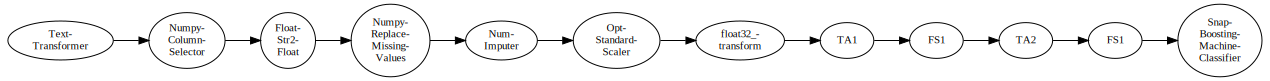

In [81]:
pipeline_model.visualize()

In [82]:
from sklearn import set_config
set_config(display="diagram")
scikit_learn_pipeline

Pipeline(steps=[('texttransformer',
                 TextTransformer(column_headers_list=['NewTextFeature_0_word2vec(preprocessed_texts)',
                                                      'NewTextFeature_1_word2vec(preprocessed_texts)',
                                                      'NewTextFeature_2_word2vec(preprocessed_texts)',
                                                      'NewTextFeature_3_word2vec(preprocessed_texts)',
                                                      'NewTextFeature_4_word2vec(preprocessed_texts)',
                                                      'NewTextFeature_5_word2vec(preprocesse...
                 autoai_libs.cognito.transforms.transform_utils.TA2(fun = numpy.add, name = 'sum', datatypes1 = ['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1 = [<cyfunction is_not_categorical at 0x7f6962208450>], datatypes2 = ['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2 = [<cyfunction is_not_categorical at 0x7f6962208450>], tgraph = None, apply_all = True, col_names = ['NewTextFeature_0_word2vec(preprocessed_texts)', 'NewTextFeature_1_word2vec(preprocessed_texts)', 'NewTextFeature_2_word2vec(preprocessed_texts)', 'NewTextFeature_3_word2vec(preprocessed_texts)', 'NewTextFeature_4_word2vec(preprocessed_texts)', 'NewTextFeature_5_word2vec(preprocessed_texts)', 'NewTextFeature_6_word2vec(preprocessed_texts)', 'NewTextFeature_7_word2vec(preprocessed_texts)', 'NewTextFeature_8_word2vec(preprocessed_texts)', 'NewTextFeature_9_word2vec(preprocessed_texts)', 'NewTextFeature_10_word2vec(preprocessed_texts)', 'NewTextFeature_11_word2vec(preprocessed_texts)', 'NewTextFeature_12_word2vec(preprocessed_texts)', 'NewTextFeature_13_word2vec(preprocessed_texts)', 'NewTextFeature_14_word2vec(preprocessed_texts)', 'NewTextFeature_15_word2vec(preprocessed_texts)', 'NewTextFeature_16_word2vec(preprocessed_texts)', 'NewTextFeature_17_word2vec(preprocessed_texts)', 'NewTextFeature_18_word2vec(preprocessed_texts)', 'NewTextFeature_19_word2vec(preprocessed_texts)', 'NewTextFeature_20_word2vec(preprocessed_texts)', 'NewTextFeature_21_word2vec(preprocessed_texts)', 'NewTextFeature_22_word2vec(preprocessed_texts)', 'NewTextFeature_23_word2vec(preprocessed_texts)', 'NewTextFeature_24_word2vec(preprocessed_texts)', 'NewTextFeature_25_word2vec(preprocessed_texts)', 'NewTextFeature_26_word2vec(preprocessed_texts)', 'NewTextFeature_27_word2vec(preprocessed_texts)', 'NewTextFeature_28_word2vec(preprocessed_texts)', 'NewTextFeature_29_word2vec(preprocessed_texts)', 'log(NewTextFeature_0_word2vec(preprocessed_texts))', 'log(NewTextFeature_1_word2vec(preprocessed_texts))', 'log(NewTextFeature_2_word2vec(preprocessed_texts))', 'log(NewTextFeature_3_word2vec(preprocessed_texts))', 'log(NewTextFeature_4_word2vec(preprocessed_texts))', 'log(NewTextFeature_5_word2vec(preprocessed_texts))', 'log(NewTextFeature_6_word2vec(preprocessed_texts))', 'log(NewTextFeature_7_word2vec(preprocessed_texts))', 'log(NewTextFeature_9_word2vec(preprocessed_texts))', 'log(NewTextFeature_11_word2vec(preprocessed_texts))', 'log(NewTextFeature_12_word2vec(preprocessed_texts))', 'log(NewTextFeature_13_word2vec(preprocessed_texts))', 'log(NewTextFeature_15_word2vec(preprocessed_texts))', 'log(NewTextFeature_16_word2vec(preprocessed_texts))', 'log(NewTextFeature_17_word2vec(preprocessed_texts))', 'log(NewTextFeature_19_word2vec(preprocessed_texts))', 'log(NewTextFeature_20_word2vec(preprocessed_texts))', 'log(NewTextFeature_22_word2vec(preprocessed_texts))', 'log(NewTextFeature_24_word2vec(preprocessed_texts))', 'log(NewTextFeature_26_word2vec(preprocessed_texts))'], col_dtypes = [dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'), dtype('f

## Some predictions

In [83]:
# The code was removed by Watson Studio for sharing.

,preprocessed_texts
0,I watch and re-watch a lot of movies per year ...
1,This film is quite stupid and illogical. I am ...
2,This is one of the weirdest movies I've ever w...
3,"Have to love Michelle Yeon in this film, she w..."
4,"What a smooth synergy of sci-fi, action, comed..."


In [84]:
clean_input = Preprocessing().check_nans(data['preprocessed_texts'])
transformed_input= Preprocessing().transform(clean_input)
data['for_prediction'] = transformed_input

No NaNs


In [85]:
#see the data
data

,preprocessed_texts,for_prediction
0,I watch and re-watch a lot of movies per year ...,watch rewatch lot movie per year hobby money i...
1,This film is quite stupid and illogical. I am ...,film quite stupid illogical pretty sure people...
2,This is one of the weirdest movies I've ever w...,one weirdest movie ive ever watched somewhat e...
3,"Have to love Michelle Yeon in this film, she w...",love michelle yeon film great usual rest well ...
4,"What a smooth synergy of sci-fi, action, comed...",smooth synergy scifi action comedy best editin...


In [86]:
input_list = list()
for row in data['for_prediction']:
    input_list.append([row])

In [87]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "X_kVsZIt_N4wyOAXPvkjI0rReJE0q4fzZpDXvMX7i_3R"
token_response = requests.post('https://iam.cloud.ibm.com/identity/token', data={"apikey":
 API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": ['preprocessed_texts'], "values": input_list}]}

response_scoring = requests.post('https://eu-de.ml.cloud.ibm.com/ml/v4/deployments/imdb_model_final/predictions?version=2023-05-09', json=payload_scoring,
 headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())

Scoring response
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [0.9166188807842924, 0.08338111921570754]], [0, [0.7841306327013434, 0.2158693672986566]], [0, [0.7048409619646661, 0.2951590380353339]], [1, [0.08740278386172307, 0.9125972161382769]], [1, [0.1830348515978495, 0.8169651484021505]]]}]}


In [88]:
cat = ['negative', 'positive']
for idx_rev in range(len(data)):
    print('----------- REVIEW TEXT -----------')
    print(data['preprocessed_texts'][idx_rev])
    print('----------------------')
    model_pred = response_scoring.json()['predictions'][0]['values'][idx_rev][0]
    print(f'Model prediction: {cat[model_pred]}')
    conf = response_scoring.json()['predictions'][0]['values'][idx_rev][1][model_pred]
    print(f'With confidence {conf}')

----------- REVIEW TEXT -----------
I watch and re-watch a lot of movies per year as a hobby (no money involved), and today I have 9988 reviews in IMDb. Last month, I received an email from IMDb listing "Everything Everywhere All at Once" as one of the Top-10 movies of 2022. In IMDb, it is informed that this flick is nominated for 10 BAFTA Awards, 240 wins and 351 nominations. I can only understand that this is a heard behavior to the promotion of studio, using "professional critics" and press to promote such a garbage. I cannot envision a normal being, without financial interest or being manipulated by critics, to enjoy this crap. It seems to be a bad trip of the writers turned into a movie by insane productors. In the end, this film is 2h 19 min of complete waste of time. My vote is one (awful).
----------------------
Model prediction: negative
With confidence 0.9166188807842924
----------- REVIEW TEXT -----------
This film is quite stupid and illogical. I am pretty sure that most pe